In [1]:
import os
import warnings
from datetime import datetime

import numpy as np
import pyart
from matplotlib import pyplot as plt
import cftime

import radar_codes
import filtering
import phase
import hydrometeors
import attenuation
import rainrate
import file_util

warnings.simplefilter('ignore')



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [82]:
#config
vol_root = '/g/data/rq0/level_1/odim_pvol'
cf_root = '/g/data/kl02/jss548/PST/polarimetric_rain/cfradial'
rf_root = '/g/data/kl02/jss548/PST/polarimetric_rain/rf3_instant_rainrate'
VERBOSE = False

rid = 2
date_str = '20200119'
# rid = 66
# date_str = '20200309'


In [83]:
#unpack and list daily zip
vol_zip = f'{vol_root}/{rid:02}/{date_str[0:4]}/vol/{rid:02}_{date_str}.pvol.zip'
temp_dir = True
vol_ffn_list = file_util.unpack_zip(vol_zip)

In [89]:
vol_ffn = vol_ffn_list[40]

In [90]:
print('processing', vol_ffn)

#read radar volume
radar = pyart.aux_io.read_odim_h5(vol_ffn, file_field_names=True)
#get time
valid_time = cftime.num2pydate(radar.time['data'][0], radar.time['units'])

#get radar band
wavelength = radar_codes.get_wavelength(vol_ffn)
if wavelength<8:
    band = 'C'
else:
    band = 'S'
if VERBOSE:
    print('band', band)

processing /jobfs/7804698.gadi-pbs/tmpz952dmtf/02_20200119_040028.pvol.h5


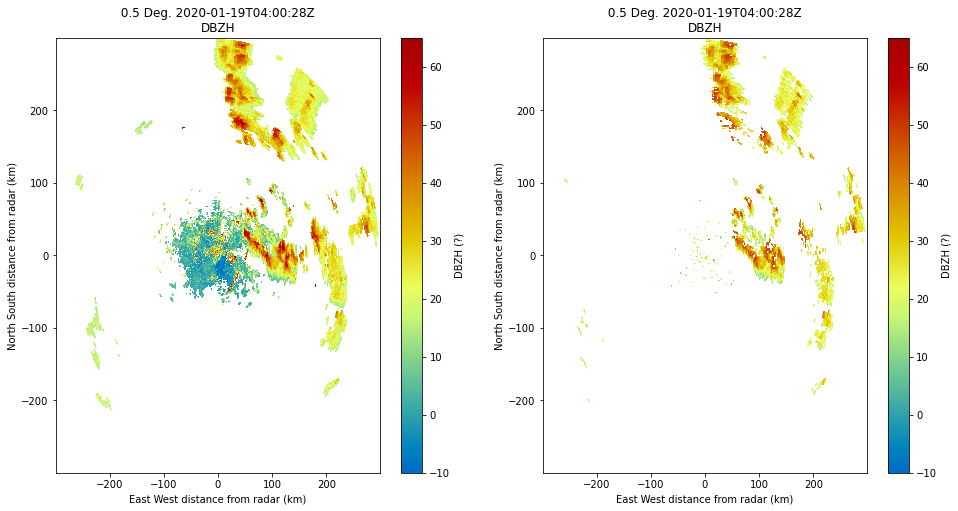

In [91]:
fig = plt.figure(figsize=[16,8])
display = pyart.graph.RadarDisplay(radar)
gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('RHOHV',0.98)
gatefilter.exclude_outside('DBZH',10,50)
gatefilter.exclude_outside('ZDR',-4,4)
ax = plt.subplot(121)
display.plot_ppi('DBZH', 0)
ax = plt.subplot(122)
display.plot_ppi('DBZH', 0,
                gatefilter=gatefilter)
#apply alpha filters to check remaining valid data

In [92]:
##################################################################################################
#
# Preprocessing
#
##################################################################################################

# Correct RHOHV
rho_corr = radar_codes.correct_rhohv(radar, snr_name='SNRH')
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing=True)

# Correct ZDR
corr_zdr = radar_codes.correct_zdr(radar, snr_name='SNRH')
radar.add_field_like('ZDR', 'ZDR_CORR', corr_zdr, replace_existing=True)

# Temperature    
height, temperature, isom = radar_codes.temperature_profile_access(radar)
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('height_over_isom', isom, replace_existing=True)

# GateFilter
gatefilter = filtering.do_gatefilter(radar,
                                     refl_name='DBZH',
                                     phidp_name="PHIDP",
                                     rhohv_name='RHOHV_CORR',
                                     zdr_name="ZDR_CORR",
                                     snr_name='SNRH')
#create fake NCP
ncp = pyart.config.get_metadata('normalized_coherent_power')
ncp['data'] = np.zeros_like(radar.fields['RHOHV']['data'])
ncp['data'][gatefilter.gate_included] = 1
radar.add_field('NCP', ncp, replace_existing=True)

# phidp filtering
phidp, kdp = phase.phidp_giangrande(radar, gatefilter, rhv_field='RHOHV_CORR', refl_field='DBZH')
radar.add_field('PHIDP_VAL', phidp, replace_existing=True)
radar.add_field('KDP_VAL', kdp, replace_existing=True)
kdp_field_name = 'KDP_VAL'
phidp_field_name = 'PHIDP_VAL'

# Hydrometeors classification
hydro_class = hydrometeors.hydrometeor_classification(radar,
                                                      gatefilter,
                                                      kdp_name=kdp_field_name,
                                                      zdr_name='ZDR_CORR',
                                                      rhohv_name='RHOHV_CORR',
                                                      refl_name='DBZH',
                                                      band=band)

radar.add_field('radar_echo_classification', hydro_class, replace_existing=True)

defaults 0.020079291458349833 0.036011856364105276


case 1 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
case 1 count [300. 349. 416. 412. 462. 468. 454. 421. 368. 322. 337. 300. 275. 225.
 197. 126.]
case 1 thresholds [250. 250. 250. 250. 250. 250. 250. 250. 225. 225. 200. 150. 150. 100.
 100.  60.]
case 2 [False False False False False  True  True  True  True  True  True]
case 2 count [ 74. 131. 166. 205. 255. 300. 349. 416. 412. 462. 468.]
case 2 thresholds [300. 300. 300. 300. 300. 250. 250. 250. 250. 250. 250.]
case 3 True
case 3 total count 5140.0
case 3 min 4150.0
case 4 True
case 4 total count 823.0
case 4 min 50

1: fitted 20-50dbZ
alpha value 0.020079291458349833


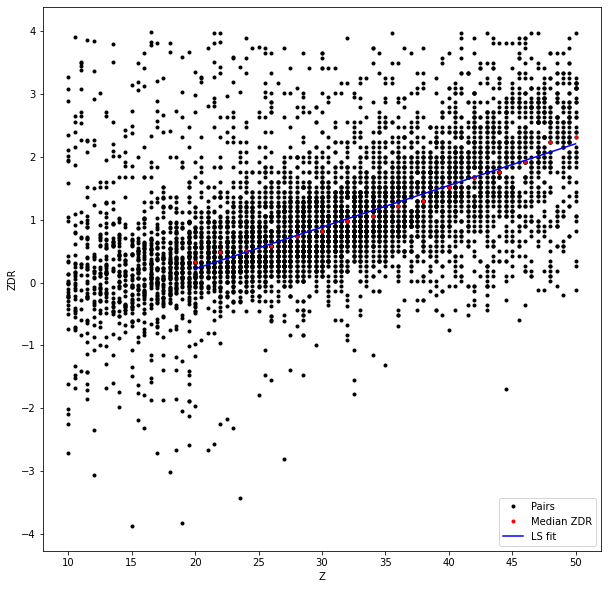

In [93]:
##################################################################################################
#
# Retrievals
#
##################################################################################################
from importlib import reload
reload(rainrate)
reload(attenuation)

#estimate alpha
alpha = attenuation.estimate_alpha_zhang2020(radar, band,
                                       refl_field='DBZH', zdr_field='ZDR_CORR', rhohv_field='RHOHV_CORR',
                                       verbose=True)

#estimate specific attenuation
if VERBOSE:
    print('alpha', alpha)
radar = attenuation.retrieve_zphi(radar, band, alpha=alpha,
                                 refl_field='DBZH', phidp_field=phidp_field_name, rhohv_field='RHOHV_CORR')

#estimate rainfall
radar = rainrate.conventional(radar, alpha=92, beta=1.7, refl_field='corrected_reflectivity')
radar = rainrate.polarimetric(radar, band, refl_field='corrected_reflectivity', kdp_field=kdp_field_name, rhohv_field='RHOHV_CORR')
